# Setting up


In [ ]:
pip install --upgrade "jax[cpu]"

In [ ]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np

# Scalar Function


`grad` takes at least one argument that is a function and a second argument for which function argument to take the derivative with respect to

In the example below, a function f(x;(a,b,c))=ax^2+bx+c is defined. 

In [ ]:
from jax import grad

In [ ]:
def f(x, pars):
    a, b, c = pars
    return a * x**2 + b * x + c

fx = grad(f)

In [ ]:
fx(2.0, [1, 2, 3])

DeviceArray(6., dtype=float64, weak_type=True)

Should avoid using integer for x because they are not differentiable

To get the derivative with respect to the second argument (the array), we use 1 for the argnums argument

In [ ]:
fp = grad(f, argnums=1)  # df / dpars, pars is arg 1

fp(2.0, np.array([1.0, 2.0, 3.0]))

DeviceArray([4., 2., 1.], dtype=float64)

In [ ]:
df = grad(f, argnums=[0, 1])

df(2.0, np.array([1., 2., 3.]))

(DeviceArray(6., dtype=float64, weak_type=True),
 DeviceArray([4., 2., 1.], dtype=float64))

`vmap` is used to create a vectorized mapping function. To use `vmap`, we have to specify which arguments to map over.

In [ ]:
from jax import vmap 

vfx = vmap(fx, in_axes=(0, None))

x = np.linspace(0, 2)

dfp = vfx(x, np.array([1., 2., 3.]))

# compare to the analytical derivative
np.allclose(dfp, np.polyval(np.polyder(np.array([1.0, 2., 3.])), x))

%timeit np.array([fx(_x, np.array([1.0, 2., 3.])) for _x in x])

1 loop, best of 5: 376 ms per loop


`vmap` is much faster, without even needing optimization. We can further improve performance with `jit`.

In [ ]:
from jax import jit

jvfx = jit(vfx)

%timeit jvfx(x, np.array([1.0, 2., 3.]))

The slowest run took 198.53 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 496 µs per loop


# Jacobian of a vector function

A function with multiple outputs, often in the form of an array. To get the full Jacobian array, define a function with a single argument. The singmant must be an array of the x, y values.

In [ ]:
from jax import jacfwd, jacrev

def f(X):
    x, y = X
    return np.array([x**2 * y,
                     5 * x + np.sin(y)])

jf = jacfwd(f)

X = np.array([1.0, 1.0])
jf(X)

DeviceArray([[2.        , 1.        ],
             [5.        , 0.54030231]], dtype=float64)

# Hessian of a function
An array of *second-order* partial derivatives of the output. It has uses in optimization, uncertainty quantification, critical point identification, etc.

In [ ]:
from jax import hessian

def f(X):
    x, y = X
    return x**3 - 2 * x * y - y**6

hessian(f)([1., 2.])

[[DeviceArray(6., dtype=float64, weak_type=True),
  DeviceArray(-2., dtype=float64, weak_type=True)],
 [DeviceArray(-2., dtype=float64, weak_type=True),
  DeviceArray(-480., dtype=float64, weak_type=True)]]

This result is equivalent to the analytical Hessian, but considerably easier to obtain. 

# Applications of AD in math


In [ ]:
# Example 1: Deriving y'(x) from f(x,y(x)) = x^3 + y^3 - 4 = 0
def f(x, y):
    return x**3 + y**3 - 4

dfdx = grad(f, 0)
dfdy = grad(f, 1)

dydx = lambda x, y: -dfdx(x, y) / dfdy(x, y)

x, y = 2.1, 3.2
dydx(x, y), -x**2 / y**2

(DeviceArray(-0.43066406, dtype=float64, weak_type=True), -0.43066406249999994)

The solver successfully reached the end of the integration interval.


(0.0, 2.0)

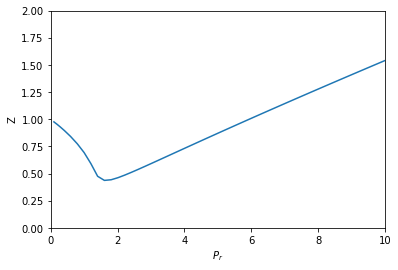

In [ ]:
# Example 2: Find the relationship between compressibility, temperature, and pressure with the van der Waal equation

# Defining constants and function
R = 0.08206
Pc = 72.9
Tc = 304.2

a = 27 * R**2 * Tc**2 / (Pc * 64)
b = R * Tc / (8 * Pc)

Tr = 1.1  # Constant for this example

def f(V, Pr, Tr):
    return R * Tr * Tc / (V - b) - a / V**2 - Pr * Pc

# Obtain a function for dV/dPr

dfdPr = jacfwd(f, 1)  # derivative of f with respect to arg at index=1: Pr
dfdV = jacfwd(f, 0)  # derivative of f with respect to arg at index=0: V

def dVdPr(Pr, V):
    return -dfdPr(V, Pr, Tr) / dfdV(V, Pr, Tr)

# Create initial condition
from scipy.optimize import root

V0 = root(f, 3.5, args=(0.1, 1.1)).x[0]

# Use ODE to analyze and plot the relationship
import numpy as np
from scipy.integrate import solve_ivp

Pr_span = (0.1, 10)
Pr_eval, h = np.linspace(*Pr_span, retstep=True)

# The ODE function is defined by jax
sol = solve_ivp(dVdPr, Pr_span, (V0,), max_step=h)
print(sol.message)

import matplotlib.pyplot as plt

Pr = sol.t  # the P_r steps used in the solution
V = sol.y[0]  # V(P_r) from the solution

Z = Pr * Pc * V / (R * Tr * Tc)  # Compressibility Z(P_r)

plt.plot(Pr, Z)
plt.xlabel('$P_r$')
plt.ylabel('Z')
plt.xlim([0, 10])
plt.ylim([0, 2])

f1:  0.08638978040861532 0.6
f2:  0.32842406163614396 1.0


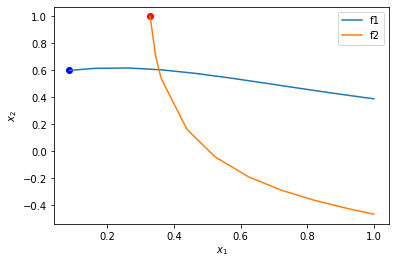

In [ ]:
# Find a solution for the set of equations: 
#   e^(-e^(-e)^(x1+x2)) = x2(1+x1^2) 
#   x1cos(x2)+x2sin(x1)=1/2

# Strategy: Find one solution to each equation 
# => Derive a differential equation for each equation that we can integrate 
# to find the curve that is defined by the implicit function

# Find one solution to each equation
import jax.numpy as np
from scipy.optimize import root

def f1(x1, x2):
    return np.exp(-np.exp(-(x1 + x2))) - x2 * (1 + x1**2)

def f2(x1, x2):
    return x1 * np.cos(x2) + x2 * np.sin(x1) - 0.5

x2_1 = 0.6  # just a guess
x1_1 = root(f1, 0, args=(x2_1,)).x[0]
print('f1: ', x1_1, x2_1)

x2_2 = 1.0
x1_2 = root(f2, 0 ,args=(x2_2,)).x[0]
print('f2: ', x1_2, x2_2)

# Obtain the dx2/dx1 differential equation using the Jacobian function

# 1st equation
df1dx1 = jacfwd(f1, 0)
df1dx2 = jacfwd(f1, 1)

def dx2dx1_1(x1, x2):
    return -df1dx1(x1, x2) / df1dx2(x1, x2)

x1_span = (x1_1, 1)
x2_0 = (x2_1, )
sol1 = solve_ivp(dx2dx1_1, x1_span, x2_0, max_step=0.1)

# 2nd equation
df2dx1 = jacfwd(f2, 0)
df2dx2 = jacfwd(f2, 1)

def dx2dx1_2(x1, x2):
    return -df2dx1(x1, x2) / df2dx2(x1, x2)

x1_span = (x1_2, 1)
x2_0 = (x2_2, )
sol2 = solve_ivp(dx2dx1_2, x1_span, x2_0, max_step=0.1)

# Plot two solutions
plt.plot(x1_1, x2_1, 'bo') # starting point we integrated from
plt.plot(sol1.t, sol1.y.T, label='f1')

plt.plot(x1_2, x2_2, 'ro') # starting point we integrated from
plt.plot(sol2.t, sol2.y.T, label='f2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend();


There is only one intersection near x1 = 0.4 and x2 = 0.2. Use that to find the only solution

In [ ]:
def objective(X):
    x1, x2 = X
    return [f1(x1, x2), f2(x1, x2)]

root(objective, [0.4, 0.6])

    fjac: array([[-0.14215877,  0.98984387],
       [-0.98984387, -0.14215877]])
     fun: array([-1.11022302e-16, -5.55111512e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.65697283e-12, -8.97716217e-12])
       r: array([1.40977408, 0.26613721, 0.83465429])
  status: 1
 success: True
       x: array([0.35324662, 0.60608174])

In [ ]:
# Example 3: In the binary, batch distillation of batch distillation of benzene (1) and toluene (2), the moles of liquid $L$ remaining as a function of the mole fraction of toluene is expressed by:
# dL / dx2 = L / (x2(k2 - 1))
# where k2 is the vapor liquid equilibrium ratio for toluene, which can be computed as:
# ki = Pi / P where Pi = 10^(Ai + Bi/(T + Ci))

# Strategy: Derive a second ODE dT/dx2 from the constraint. The constraint is implicit in T, so
# We computed it as dT / dx2 = -df/dx2/df/dT where f(x2,T) = k1(T)x1 + k2(T)x2 - 1 =0

# Finding the initial temperature from the constraint

P = 760 * 1.2 # mmHg
A1, B1, C1 = 6.90565, -1211.033,  220.79
A2, B2, C2 = 6.95464, -1344.8, 219.482

def k1(T):
    return 10**(A1 + B1 / (C1 + T)) / P

def k2(T):
    return 10**(A2 + B2 / (C2 + T)) / P

def f(x2, T):
    x1 = 1 - x2
    return k1(T) * x1 + k2(T) * x2 - 1

T0, = root(lambda T: f(0.4, T), 96).x
print(f'The initial temperature is {T0:1.2f} degC.')

The initial temperature is 95.59 degC.


In [ ]:
# Compute the derivative

dfdx2 = grad(f, 0)
dfdT = grad(f, 1)

def dTdx2(x2, T):
    return -dfdx2(x2, T) / dfdT(x2, T)

def ode(x2, X):
    L, T = X
    dLdx2 = L / (x2 * (k2(T) - 1))
    return [dLdx2, dTdx2(x2, T)]

At x2=0.80 there are 14.04 moles of liquid left at 108.57 degC


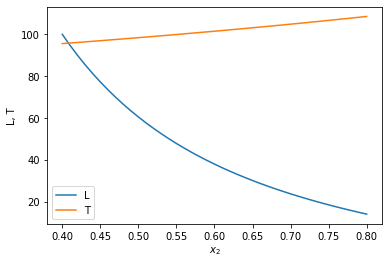

In [ ]:
# Solve and plot the ODE

x2span = (0.4, 0.8)
X0 = (100, T0)
sol = solve_ivp(ode, x2span, X0, max_step=0.01)

plt.plot(sol.t, sol.y.T)
plt.legend(['L', 'T']);
plt.xlabel('$x_2$')
plt.ylabel('L, T')
x2 = sol.t
L, T = sol.y
print(f'At x2={x2[-1]:1.2f} there are {L[-1]:1.2f} moles of liquid left at {T[-1]:1.2f} degC')

In [ ]:
# The liquid level drops and the temperature rises 
# Verifying that the constraint is met

constraint = k1(T) * (1 - x2) + k2(T) * x2 - 1
print(np.allclose(constraint, 0))

True


In [ ]:
# Example 4: Solve the following nonlinear equations
#   2 + x + y - x^2 + 8xy + y^3 = 0
#   1 + 2x - 3y + x^2 + xy - ye^x = 0

# Rewrite the function as 
#   f(x,y) = (2 + x + y) + lambda(- x^2 + 8 x y + y^3) = 0
#   g(x,y) = (1 + 2x - 3y) + lambda(x^2 + xy - y e^x) = 0

# At lambda = 0,
#   x + y = -2
#   2x - 3y = -1

x0 = np.linalg.solve([[1., 1.],
                      [2., -3.]],
                      [-2, -1])
print(x0)

# I'm not sure how but this works
from jax.experimental.ode import odeint
from jax import jacrev

def F(X, _lam):
    x, y = X
    return np.array([2 + x + y + _lam * (- x**2 + 8 * x * y + y**3),
                     1 + 2*x - 3*y + _lam * (x**2 + x * y - y * np.exp(x))])

JF = jacrev(F, 0)
JL = jacrev(F, 1)

def dXdlambda(X, _lam):
    return np.linalg.solve(JF(X, _lam), -JL(X, _lam))
    
lambda_span = np.array((0.0, 1.0))
                         
Xsol = odeint(dXdlambda, x0, lambda_span)
Xsol[-1]

[-1.4 -0.6]


DeviceArray([-1.00000007e+00, -1.77668136e-08], dtype=float64)

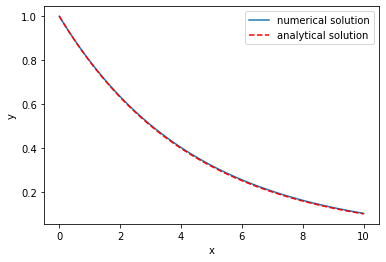

In [ ]:
# Creative solutions to an ODE
# Discretize the region want solution on -> Set up an objective function -> Computes the error and initial condition
# -> Minimize that

import jax.numpy as np

x = np.linspace(0, 10, 100)

def ode(x, y):
    return -0.23 * y

y0 = 1

# we solve for the solution y directly by minimizing this error function.
def objective(y):      
    dydx = np.zeros(y.shape)
    dydx = dydx.at[0].set((y[1] - y[0]) / (x[1] - x[0]))
    dydx = dydx.at[1:-1].set((y[1:-1] - y[:-2]) / (x[1:-1] - x[:-2]))
    dydx = dydx.at[-1].set((y[-1] - y[-2]) / (x[-1] - x[-2]))
   
    errs = ode(x, y) - dydx
    
    return np.mean(errs**2) + (y[0] - y0)**2

from scipy.optimize import minimize

sol = minimize(objective, -x, jac=grad(objective))


import matplotlib.pyplot as plt
plt.plot(x, sol.x, label='numerical solution')
plt.plot(x, y0 * np.exp(-0.23 * x), 'r--', label='analytical solution')
         
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

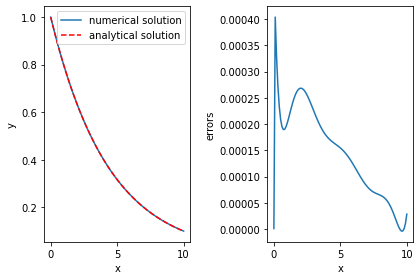

In [ ]:
import jax.numpy as np

x = np.linspace(0, 10, 100)

def ode(x, y):
    return -0.23 * y

y0 = 1

# we solve for the solution y directly by minimizing this error function.
def objective(y):      

    p = np.polyfit(x, y, 8)
    dp = np.polyder(p)
    dydx = np.polyval(dp, x)
   
    errs = ode(x, y) - dydx
    
    return np.mean(errs**2) + (y[0] - y0)**2

from scipy.optimize import minimize

sol = minimize(objective, -x, jac=grad(objective))

plt.subplot(1, 2, 1)
plt.plot(x, sol.x, label='numerical solution')
plt.plot(x, y0 * np.exp(-0.23 * x), 'r--', label='analytical solution')
         
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(x, sol.x - y0 * np.exp(-0.23 * x))
plt.xlabel('x')
plt.ylabel('errors')
plt.tight_layout();

# Applications in science and engineering

In [ ]:
# Example 1: Shows that Gibbs-Duhem is satisfied

A12, A21 = 2.04, 1.5461  # Acetone/water

def GexRT(n1, n2):
    n = n1 + n2
    x1 = n1 / n
    x2 = n2 / n
    return n * x1 * x2 * (A21 * x1 + A12 * x2)

lngamma1 = grad(GexRT)     # dGex/dn1
lngamma2 = grad(GexRT, 1)  # dGex/dn2

n1, n2 = 1.0, 2.0
n = n1 + n2
x1 = n1 / n
x2 = n2 / n

# Evaluate the activity coefficients
print('AD:         ',lngamma1(n1, n2), lngamma2(n1, n2))

# Compare that to these analytically derived activity coefficients
print('Analytical: ', (A12 + 2 * (A21 - A12) * x1) * x2**2, (A21 + 2 * (A12 - A21) * x2) * x1**2)

# Demonstration of the Gibbs-Duhem rule
dg1 = vmap(grad(lngamma1))
dg2 = vmap(grad(lngamma2))

n = 1.0 # Choose a basis number of moles
x1 = np.linspace(0, 1)
x2 = 1 - x1
n1 = n * x1
n2 = n - n1

GD = x1 * dg1(n1, n2) + x2 * dg2(n1, n2)

print(np.allclose(GD, np.zeros(len(GD))))

AD:          0.7603259259259258 0.24495925925925932
Analytical:  0.760325925925926 0.24495925925925924
True


In [ ]:
# Example 2: Compute pressure of a solid under isotropic strain

E0, B0, BP, V0 = -56.466,   0.49,    4.753,  16.573

def Murnaghan(vol):
    E = E0 + B0 * vol / BP * (((V0 / vol)**BP) / (BP - 1.0) + 1.0) - V0 * B0 / (BP - 1.)
    return E

def P(vol):
    dEdV = grad(Murnaghan)
    return -dEdV(vol) * 160.21773  # in Gpa

print(P(V0)) # Pressure at the minimum in energy is zero
print(P(0.99 * V0))  # Compressed

-0.0
0.8081676846907802


In [ ]:
# Example 3: Heat capacity from the Shomate equations

A, B, C, D, E, F, G, H = [30.09200,
                          6.832514,
                          6.793435,
                          -2.534480,
                          0.082139,
                          -250.8810,
                          223.3967,
                          -241.8264]

def dH(T):
    'H - H0 in kJ / mol'
    T = np.atleast_1d(T)
    t = ((T / 1000)[:, None])**np.array([1, 2, 3, 4, -1, 0, 0])
    return (np.array([[A, B / 2, C / 3, D / 4, -E, F, -H]]) @ t.T).squeeze()

Cp = grad(dH)
print(f'The Cp for water is {Cp(600.0) * 1000} J / mol / K')

def aCp(T):
    T = np.atleast_1d(T)
    t = (T / 1000)[:, None]**np.array([0, 1, 2, 3, -2])
    return (np.array([[A, B, C, D, E]]) @ t.T).squeeze()

print(f'The Cp for water is {aCp(600.0)} J / mol / K')

dH([600, 700])

vmap(Cp)(np.array([600.0, 700.0])) * 1000

The Cp for water is 36.317861208888885 J / mol / K
The Cp for water is 36.317861208888885 J / mol / K


DeviceArray([36.31786121, 37.50184692], dtype=float64)

In [ ]:
# Example 4: Lennord Jones potential with forces

def get_potential_energy(params, positions):
    """Compute the energy of a molecular Lennard-Jones system."""

    sigma = params.get('sigma', 1.0)
    epsilon = params.get('epsilon', 1.0)

    r2 = np.sum((positions[:, None] - positions[None, :])**2, axis=2)

    R2 = r2[np.triu(r2) > 0] # get only the upper triangle
    c6 = (sigma**2 / R2)**3
    c12 = c6**2
    energy = 4 * epsilon * np.sum(c12 - c6)
    return energy

    get_potential_energy({}, np.array([[0.0, 0.0, 0.0],
                                   [0.0, 0.0, 2**(1 / 6)]]))
    
    def get_forces(params, positions):
      dedr = grad(get_potential_energy, 1)
      return -dedr(params, positions)

    get_forces({}, np.array([[0.0, 0.0, 0.0],
                         [0.0, 0.0, 2.0**(1/6)]]))

# Applications of AD in machine learning

In [ ]:
# Example 1: Neural network

import jax
import jax.numpy as np
from jax import random
key = random.PRNGKey(12) # initialize random number generator.

def init_params(scale, layers):
    '''
    scale: float
    layers: integers for neurons in each layer
    '''
    weights = []
    biases = []
    for i in range(len(layers) - 1):
        in_d = layers[i]
        out_d = layers[i + 1]

        weights += [jax.random.normal(key, (in_d, out_d)) * scale]
        biases += [jax.random.normal(key, (out_d,)) * scale]
        
    return dict(weights=weights, biases=biases)

def nn(params, X, activation=jax.nn.tanh):
    out = activation(X @ params['weights'][0] + params['biases'][0])

    for i in range(1, len(params['weights']) - 2):
        out = activation(out @ params['weights'][i] + params['biases'][i])

    # no activation on the output, just linear combination
    return out @ params['weights'][-1] + params['biases'][-1]

pars = init_params(0.1, (1, 5, 1))

with np.printoptions(precision=3):
    print(pars)

nn(pars, np.array([0.1]))

def objective(pars):
    p = nn(pars, x)
    errs = p - y
    return (errs.T @ errs).squeeze()
    x = np.linspace(0, 1, 10)[:, None]
y = x**(1/3)

objective(pars)

import jax.example_libraries.optimizers as jax_opt
from jax import jit
from jax import value_and_grad

opt_init, opt_update, get_params = jax_opt.adam(1e-2)

opt_state = opt_init(pars)

@jit
def step(i, opt_state):
    value, grads = value_and_grad(objective)(get_params(opt_state))
    return value, opt_update(i, grads, opt_state)

for i in range(1000000):
    value, opt_state = step(i, opt_state)
    if np.abs(value) < 1e-4:
        break

print(i, value)

import matplotlib.pyplot as plt

X = np.linspace(0, 1)[:, None]

plt.plot(x, y, 'b.')
plt.plot(X, nn(get_params(opt_state), X))
plt.xlabel('x')
plt.ylabel('y');

from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(5,), activation='tanh', solver='lbfgs')

model.fit(x, y.ravel())

xx = np.linspace(0, 1)[:, None]
plt.plot(x, y, 'b.')
plt.plot(xx, model.predict(xx))
plt.xlabel('x')
plt.ylabel('y');

pars = get_params(opt_state)

xx = np.linspace(-5, 5)[:, None]
plt.plot(x, y, 'b.')
plt.plot(xx, nn(pars, xx))

{'weights': [DeviceArray([[ 0.094, -0.068, -0.053, -0.247, -0.072]], dtype=float64), DeviceArray([[ 0.094],
             [-0.068],
             [-0.053],
             [-0.247],
             [-0.072]], dtype=float64)], 'biases': [DeviceArray([ 0.094, -0.068, -0.053, -0.247, -0.072], dtype=float64), DeviceArray([0.037], dtype=float64)]}


UnboundLocalError: ignored